In [1]:
import os
import sys
import math
import h5py
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.ticker as ticker
from matplotlib import cm  #to get python's normal library of colormaps
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")  #hides "MatplotlibDeprecationWarning" with pcolormesh

In [2]:
#the only cell with variables you need to change, unless you are not Ben (will need to change cell #3 too)

# file_date = '20170610'           #which date to create the APR plot for
# start_time0 = '20170610,203000'  #start date,time for the APR plot
# end_time0 = '20170610,205400'    #end date,time for the APR plot
# full = False                     #do the above time ranges encapsulate the entire convective module?

file_date = '20170601'           #which date to create the APR plot for
start_time0 = '20170601,191305'  #start date,time for the APR plot
end_time0 = '20170601,192900'    #end date,time for the APR plot
full = False                     #do the above time ranges encapsulate the entire convective module?

# file_date = '20170611'           #which date to create the APR plot for
# start_time0 = '20170611,185900'  #start date,time for the APR plot
# end_time0 = '20170611,191830'    #end date,time for the APR plot
# full = False                     #do the above time ranges encapsulate the entire convective module?

In [3]:
#other users will also have to change day_folder, apr_folder, dawn_csv_path, and drop_csv_path filepaths
start_time = datetime.strptime(start_time0, '%Y%m%d,%H%M%S')
end_time = datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

#locations of the APR folder/files
day_folder = os.path.join(os.getcwd(), file_date)
apr_folder = os.path.join(day_folder, 'APR_files')

#load the final DAWN and final Dropsonde CSVs
dawn_csv_path = os.path.join(day_folder, 'final_dawn_' + file_date + '.csv')
dawn_csv = pd.read_csv(dawn_csv_path)

drop_csv_path = os.path.join(day_folder, 'final_dropsonde_' + file_date + '.csv')
drop_csv = pd.read_csv(drop_csv_path)

In [4]:
#create a list of all the given day's desired range's APR files:    #for APR_plots.py
apr_file_list = []

range_full_start = int(start_time0[-6:])
range_full_end = int(end_time0[-6:])

first_file = 'blank'
for x in sorted(os.listdir(apr_folder)):        #sorted() makes sure the code goes through the files in alphabetical order
    if x[0:3] == '.DS':         #delete stupid .DS_Store files (always haunt me)
        os.remove(apr_folder + '/' + x)       #will show up if you delete a file
    elif int(x[22:28]) <= range_full_start:
        first_file = apr_folder + '/' + x     #first_file will always be the file immediately before (or equal to) start_time0, so as to plot exactly all necessary (but no unnecessary) APR files for the desired time range
    elif int(x[22:28]) >= range_full_end:
        continue
    else:
        if (first_file not in apr_file_list) and (first_file != 'blank'):
            apr_file_list.append(first_file)
        apr_file_list.append(apr_folder + '/' + x)
        
if apr_file_list == []:             #accounts for if start_time0 is greater than all of the file times, but still within the last file's time range; also accounts for start/end times equaling the times of adjacent files
    apr_file_list.append(first_file)

apr_file_list

['/Users/brodenkirch/Desktop/CPEX/Coding/20170601/APR_files/APR3-L2ZV_DC8_20170601191027_R2_KUsKAs.h5']

In [5]:
#set some baseline plot displays

# #matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
# matplotlib.rcParams['axes.labelsize'] = 35
# matplotlib.rcParams['axes.titlesize'] = 45
# matplotlib.rcParams['axes.labelweight'] = 'bold'
# matplotlib.rcParams['axes.titleweight'] = 'bold'
# matplotlib.rcParams['xtick.labelsize'] = 27
# matplotlib.rcParams['ytick.labelsize'] = 27
# matplotlib.rcParams['legend.fontsize'] = 35
# #matplotlib.rcParams['legend.facecolor'] = 'w'
# matplotlib.rcParams['font.family'] = 'arial'
# #matplotlib.rcParams['hatch.linewidth'] = 0.3

#matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 45
matplotlib.rcParams['axes.titlesize'] = 55
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 37
matplotlib.rcParams['ytick.labelsize'] = 37
matplotlib.rcParams['legend.fontsize'] = 35
#matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['font.family'] = 'arial'
#matplotlib.rcParams['hatch.linewidth'] = 0.3


In [6]:
#Calculate time range in minutes, have a tick for each minute
num_minutes = (end_time - start_time).total_seconds() // 60
fig_length = num_minutes * 2

#Calculate height range of the plot, based on the maximum height of all DAWN profiles
height_max = dawn_csv['Height [m]'].max()
y_max = math.ceil(height_max / 1000) * 1000  #round height_max up to the nearest 1000

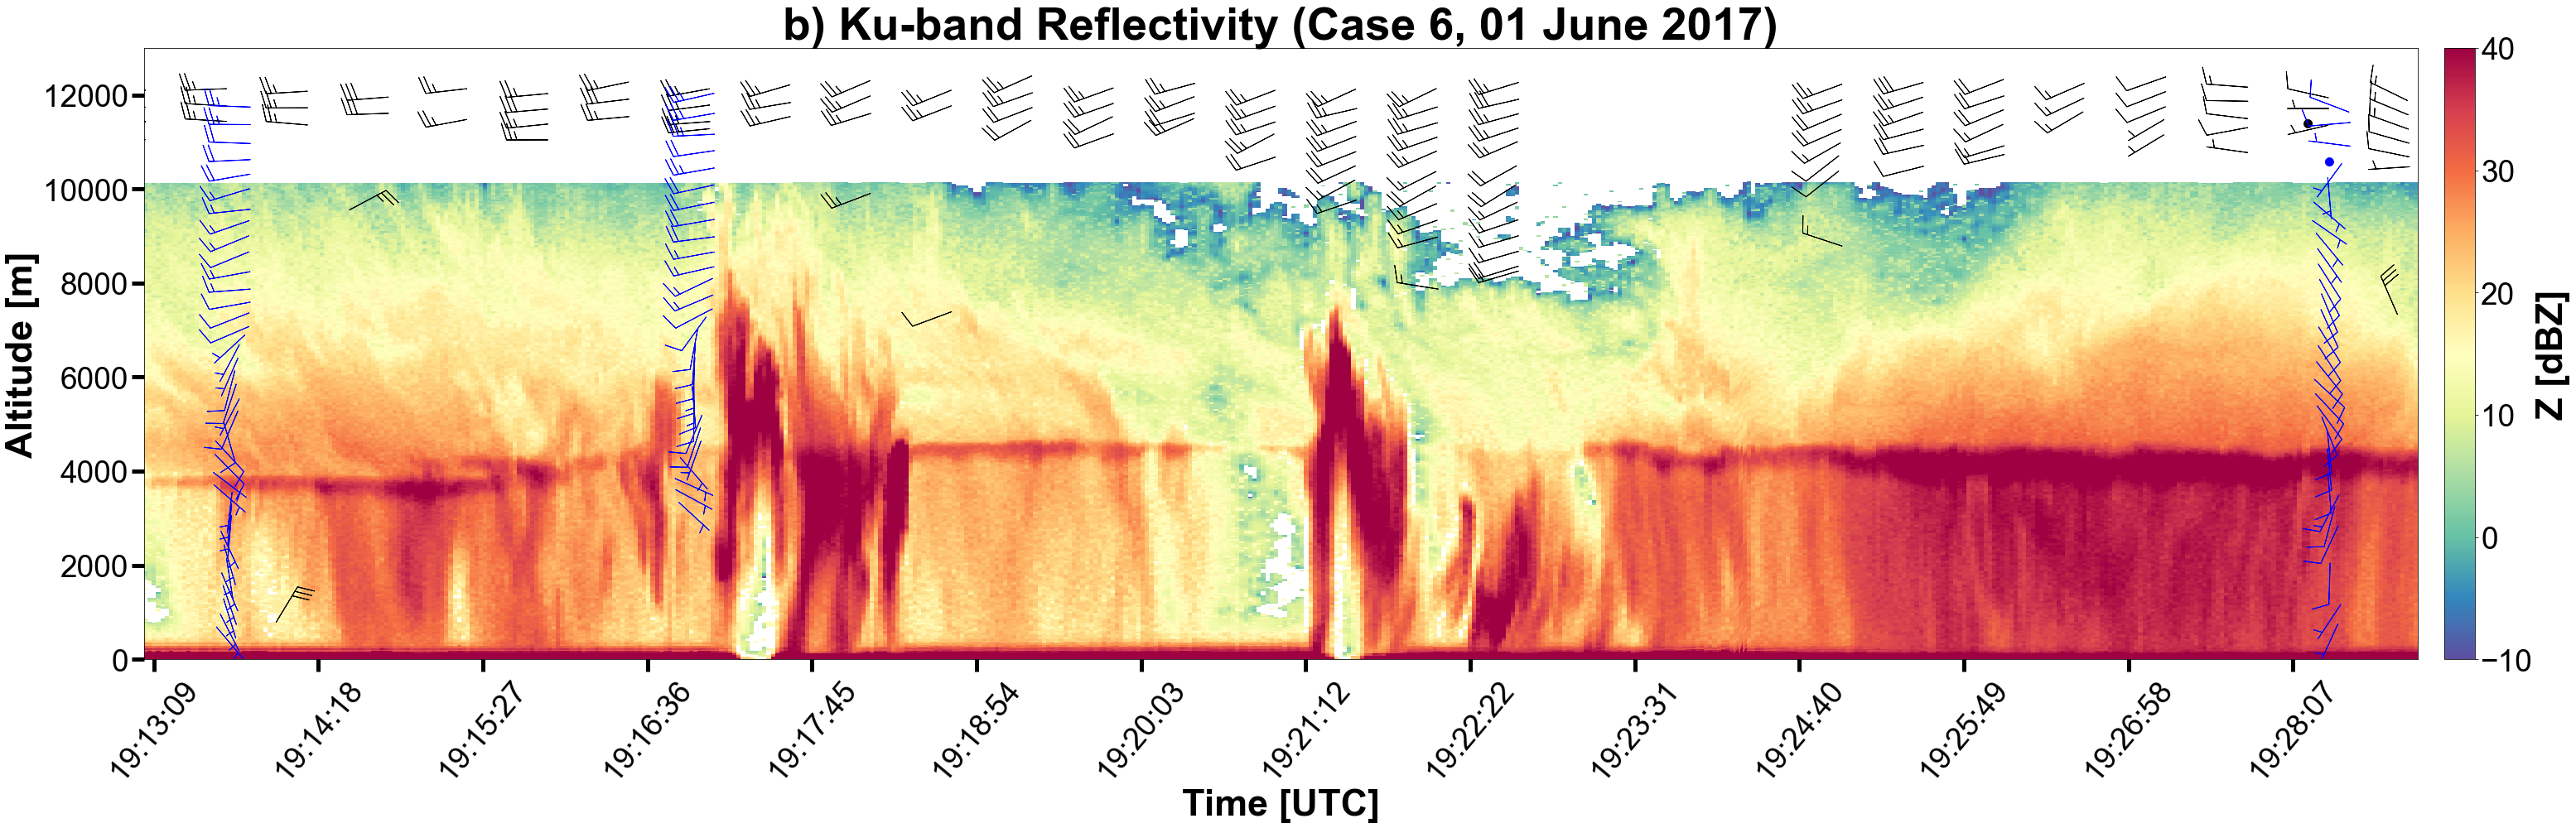

In [7]:
#plotting a time-series plot of just Ku-band reflectivity vs. height
ylim=[0,y_max]
vlim=[-10,40]
vel_lim=[-10,10]

#Low resolution ('lores') radar variables in APR hdf files ('hires' for w_band)
ku_band = 'zhh14' #Ku-band reflectivity
ka_band = 'zhh35' #Ka-band reflectivity
vel = 'vel14c' #Mean Doppler Velocity dealiased and from Ku&Ka band

if full:
    plot_save_name = file_date + '_SinglePanel_full.png'
else:
    plot_save_name = file_date + '_SinglePanel_' + start_time0[-6:] + '-' + end_time0[-6:] + '.png'

#fig,axes = plt.subplots(1,1,figsize=(fig_length,14))  #use for AGU Paper Figure 1a and general plots
fig,axes = plt.subplots(1,1,figsize=(48,14))          #use for AGU Paper Figure 1b, 12a
#fig,axes = plt.subplots(1,1,figsize=(24,8))           

for file in apr_file_list:
    
    #find the APR file of interest (for the desired datetime)
    apr_file = h5py.File(file, 'r')

    #grab the radar variables of interest
    if 'lores' in apr_file.keys():

        if ku_band in apr_file['lores'].keys():
            try:   #some APR files have corrupted Ku-band data; if so, skip plotting the Ku-band for that file
                   #corrupted: "OSError: Can't read data (inflate() failed)"
                ku_data = apr_file['lores'][ku_band][:]

                #mask the missing Ku-band data (values of -99.99)
                ku_masked = np.ma.masked_where(ku_data <= -99, ku_data)
                ku_masked = np.ma.masked_where(np.isnan(ku_masked), ku_masked)  #masks NaN values (not masked in previous line)
                ku_good = True
            except:
                ku_good = False 

        #if Ku-band is available
        if (ku_band in apr_file['lores'].keys()):            
            time = apr_file['lores']['scantime'][:]
            alt3d = apr_file['lores']['alt3D'][:]

            #Convert 'lo-res' APR times to datetimes
            time_dates = np.empty(time.shape, dtype=object)
            for i in np.arange(0, time.shape[0]):
                for j in np.arange(0, time.shape[1]):
                    #tmp = datetime.datetime(time[i,j])
                    tmp = datetime.utcfromtimestamp(time[i,j])
                    time_dates[i,j] = tmp

            #Create a time at each gate (assuming it is the same down each ray, there is a better way to do this)      
            time_gate = np.empty(alt3d.shape,dtype=object)
            for k in np.arange(0,alt3d.shape[0]):
                for i in np.arange(0,time_dates.shape[0]):
                    for j in np.arange(0,time_dates.shape[1]):
                        time_gate[k,i,j] = time_dates[i,j]        

            time3d = np.copy(time_gate)

            #plot the APR data factoring in the aircraft roll (ray adjustment)
            #choose the "pseudo-nadir" ray factoring in aircraft roll
            roll = apr_file['lores']['roll'][:]
            ray_angles = np.linspace(-25,25,24)[:-1]  #in degrees; omits 24th ray, which doesn't have data for Ku/Ka bands
            for scan in range(roll.shape[1]):
                ac_roll = np.mean(roll[:,scan])  #roll varies slightly w/ray, so take the average roll value for a given scan and use that for ray adjustment
                ray_use = np.argmin(np.abs(ray_angles - ac_roll))  #the index of the ray whose angle is closest to that of ac_roll    

                #scan + 2 (and not scan + 1) is needed because pcolormesh colors the grid cell from the  
                #grid cell's time to the subsequent grid cell's time.  If a subsequent grid cell does not exist,  
                #then pcolormesh cannot/doesn't color the grid cell (remember, slicing is right side EXCLUSIVE, 
                #so scan:scan + 1 is only 1 element and thus doesn't have a subsequent cell!)
                #by this same logic, scan:scan + 2 will only color one grid cell, since the 2nd (and last) 
                #element/grid cell doesn't have a subsequent grid cell
                if ku_band in apr_file['lores'].keys() and ku_good:
                    pm0 = axes.pcolormesh(time3d[:,ray_use,scan:scan+2], alt3d[:,ray_use,scan:scan+2],
                                          ku_masked[:,ray_use,scan:scan+2], cmap=cm.Spectral_r,vmin=vlim[0],vmax=vlim[1])
    
    apr_file.close()

cbar0 = plt.colorbar(pm0, ax=axes, pad = 0.01)
cbar0.set_label('Z [dBZ]')
axes.set_title('b) Ku-band Reflectivity (Case 6, 01 June 2017)')

# dawn_skip = slice(None,None,7)   #only plot every 7th value
# drop_skip = slice(None,None,20)  #only plot every 20th value
dawn_skip = slice(None,None,10)   #only plot every 10th value
drop_skip = slice(None,None,25)  #only plot every 25th value

#set the plot start time as the beginning time of the first APR file and the
    #plot end time as the end time of the last APR file
range_start = datetime.strptime(start_time0, '%Y%m%d,%H%M%S') 
range_end = datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

axes.barbs(pd.to_datetime(dawn_csv['Time [UTC]'])[dawn_skip], dawn_csv['Height [m]'][dawn_skip], 
           dawn_csv['U Comp of Wind [m/s]'][dawn_skip], dawn_csv['V Comp of Wind [m/s]'][dawn_skip], 
           fill_empty = True, length = 10, pivot='middle', sizes=dict(emptybarb=0.1), barbcolor = 'k')
axes.barbs(pd.to_datetime(drop_csv['Time [UTC]'])[drop_skip], drop_csv['Height [m]'][drop_skip], 
           drop_csv['U Comp of Wind [m/s]'][drop_skip], drop_csv['V Comp of Wind [m/s]'][drop_skip], 
           fill_empty = True, length = 10, pivot='middle', sizes=dict(emptybarb=0.1), barbcolor = 'b')
axes.set_ylabel('Altitude [m]')
axes.set_xlabel('Time [UTC]')
axes.set_ylim([ylim[0],ylim[1]])
axes.tick_params(axis='x', rotation = 50)
axes.tick_params(length = 15, width = 5)
axes.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
axes.xaxis.set_major_locator(ticker.MaxNLocator(num_minutes))      #sets number of ticks
axes.set_xlim([np.datetime64(range_start),np.datetime64(range_end)])    
    #use the above line to narrow the plot's time range (even within a file!!)
        #range_start and range_end must be a datetime object or a string with the 
            #format: 'YYYY-MM-DD HH:MM:SS' or 'YYYY-MM-DDTHH:MM:SS'

plt.tight_layout()

#save the figure
#plt.savefig(os.path.join(day_folder, plot_save_name), bbox_inches = 'tight')
plt.savefig('/Users/brodenkirch/Desktop/Figure1b.png', bbox_inches = 'tight')
plt.show()  #plt.show() must come after plt.savefig() in order for the image to save properly
plt.close()

In [8]:
# #plotting a time-series plot of Ku-band reflectivity, Ka-band reflectivity, and Doppler Velocity vs. height
# ylim=[0,y_max]
# vlim=[-10,40]
# vel_lim=[-10,10]

# #Low resolution ('lores') radar variables in APR hdf files ('hires' for w_band)
# ku_band = 'zhh14' #Ku-band reflectivity
# ka_band = 'zhh35' #Ka-band reflectivity
# vel = 'vel14c' #Mean Doppler Velocity dealiased and from Ku&Ka band

# if full:
#     plot_save_name = file_date + '_ThreePanel_full.png'
# else:
#     plot_save_name = file_date + '_ThreePanel_' + start_time0[-6:] + '-' + end_time0[-6:] + '.png'

# fig,axes = plt.subplots(3,1,figsize=(fig_length,36))

# for file in apr_file_list:
    
#     #find the APR file of interest (for the desired datetime)
#     apr_file = h5py.File(file, 'r')

#     #grab the radar variables of interest
#     if 'lores' in apr_file.keys():

#         if ku_band in apr_file['lores'].keys():
#             try:   #some APR files have corrupted Ku-band data; if so, skip plotting the Ku-band for that file
#                    #corrupted: "OSError: Can't read data (inflate() failed)"
#                 ku_data = apr_file['lores'][ku_band][:]

#                 #mask the missing Ku-band data (values of -99.99)
#                 ku_masked = np.ma.masked_where(ku_data <= -99, ku_data)
#                 ku_masked = np.ma.masked_where(np.isnan(ku_masked), ku_masked)  #masks NaN values (not masked in previous line)
#                 ku_good = True
#             except:
#                 ku_good = False

#         if ka_band in apr_file['lores'].keys():
#             try:   #some APR files have corrupted Ka-band data; if so, skip plotting the Ka-band for that file
#                    #corrupted: "OSError: Can't read data (inflate() failed)"
#                 ka_data = apr_file['lores'][ka_band][:]

#                 #mask the missing Ka-band data (values of -99.99)
#                 ka_masked = np.ma.masked_where(ka_data <= -99, ka_data)
#                 ka_masked = np.ma.masked_where(np.isnan(ka_masked), ka_masked)  #masks NaN values (not masked in previous line)
#                 ka_good = True
#             except:
#                 ka_good = False
                
#         if vel in apr_file['lores'].keys():
#             try:   #some APR files have corrupted Velocity data; if so, skip plotting velocity for that file
#                    #corrupted: "OSError: Can't read data (inflate() failed)"
#                 vel_data = apr_file['lores'][vel][:]

#                 #mask the missing Velocity data (values < -30 (changed from original -99.99))
#                 vel_masked = np.ma.masked_where(vel_data <= -99, vel_data)
#                 vel_masked = np.ma.masked_where(np.isnan(vel_masked), vel_masked)  #masks NaN values (not masked in previous line)
#                 vel_good = True
#             except:
#                 vel_good = False 

#         #if Ku-band or Ka-band or Doppler Velocity is available
#         if (ku_band in apr_file['lores'].keys()) or (ka_band in apr_file['lores'].keys()) or (vel in apr_file['lores'].keys()):            
#             time = apr_file['lores']['scantime'][:]
#             alt3d = apr_file['lores']['alt3D'][:]

#             #Convert 'lo-res' APR times to datetimes
#             time_dates = np.empty(time.shape, dtype=object)
#             for i in np.arange(0, time.shape[0]):
#                 for j in np.arange(0, time.shape[1]):
#                     #tmp = datetime.datetime(time[i,j])
#                     tmp = datetime.utcfromtimestamp(time[i,j])
#                     time_dates[i,j] = tmp

#             #Create a time at each gate (assuming it is the same down each ray, there is a better way to do this)      
#             time_gate = np.empty(alt3d.shape,dtype=object)
#             for k in np.arange(0,alt3d.shape[0]):
#                 for i in np.arange(0,time_dates.shape[0]):
#                     for j in np.arange(0,time_dates.shape[1]):
#                         time_gate[k,i,j] = time_dates[i,j]        

#             time3d = np.copy(time_gate)

#             #plot the APR data factoring in the aircraft roll (ray adjustment)
#             #choose the "pseudo-nadir" ray factoring in aircraft roll
#             roll = apr_file['lores']['roll'][:]
#             ray_angles = np.linspace(-25,25,24)[:-1]  #in degrees; omits 24th ray, which doesn't have data for Ku/Ka bands
#             for scan in range(roll.shape[1]):
#                 ac_roll = np.mean(roll[:,scan])  #roll varies slightly w/ray, so take the average roll value for a given scan and use that for ray adjustment
#                 ray_use = np.argmin(np.abs(ray_angles - ac_roll))  #the index of the ray whose angle is closest to that of ac_roll    

#                 #scan + 2 (and not scan + 1) is needed because pcolormesh colors the grid cell from the  
#                 #grid cell's time to the subsequent grid cell's time.  If a subsequent grid cell does not exist,  
#                 #then pcolormesh cannot/doesn't color the grid cell (remember, slicing is right side EXCLUSIVE, 
#                 #so scan:scan + 1 is only 1 element and thus doesn't have a subsequent cell!)
#                 #by this same logic, scan:scan + 2 will only color one grid cell, since the 2nd (and last) 
#                 #element/grid cell doesn't have a subsequent grid cell
#                 if ku_band in apr_file['lores'].keys() and ku_good:
#                     pm0 = axes[0].pcolormesh(time3d[:,ray_use,scan:scan+2], alt3d[:,ray_use,scan:scan+2],
#                                              ku_masked[:,ray_use,scan:scan+2], cmap=cm.Spectral_r,vmin=vlim[0],vmax=vlim[1])
#                 if ka_band in apr_file['lores'].keys() and ka_good:
#                     pm1 = axes[1].pcolormesh(time3d[:,ray_use,scan:scan+2], alt3d[:,ray_use,scan:scan+2],
#                                              ka_masked[:,ray_use,scan:scan+2], cmap=cm.Spectral_r,vmin=vlim[0],vmax=vlim[1])
#                 if vel in apr_file['lores'].keys() and vel_good:
#                     pm2 = axes[2].pcolormesh(time3d[:,ray_use,scan:scan+2], alt3d[:,ray_use,scan:scan+2],
#                                              vel_masked[:,ray_use,scan:scan+2], cmap=cm.seismic,vmin=vel_lim[0],vmax=vel_lim[1])
    
#     apr_file.close()

# cbar0 = plt.colorbar(pm0, ax=axes[0], pad = 0.01)
# cbar0.set_label('Z [dBZ]')
# axes[0].set_title('Ku-band Reflectivity (Case 1, 10 June 2017)')

# cbar1 = plt.colorbar(pm1, ax=axes[1], pad = 0.01)
# cbar1.set_label('Z [dBZ]')
# axes[1].set_title('Ka-band Reflectivity')

# cbar2 = plt.colorbar(pm2, ax=axes[2], pad = 0.01)
# cbar2.set_label('Doppler Velocity [m/s]')
# axes[2].set_title('Doppler Velocity')

# dawn_skip = slice(None,None,7)   #only plot every 7th value
# drop_skip = slice(None,None,20)  #only plot every 20th value

# #set the plot start time as the beginning time of the first APR file and the
#     #plot end time as the end time of the last APR file
# range_start = datetime.strptime(start_time0, '%Y%m%d,%H%M%S') 
# range_end = datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

# for i in range(3):
#     axes[i].barbs(pd.to_datetime(dawn_csv['Time [UTC]'])[dawn_skip], dawn_csv['Height [m]'][dawn_skip], 
#                   dawn_csv['U Comp of Wind [m/s]'][dawn_skip], dawn_csv['V Comp of Wind [m/s]'][dawn_skip], 
#                   fill_empty = True, length = 7, pivot='middle', sizes=dict(emptybarb=0.075), barbcolor = 'k')
#     axes[i].barbs(pd.to_datetime(drop_csv['Time [UTC]'])[drop_skip], drop_csv['Height [m]'][drop_skip], 
#                   drop_csv['U Comp of Wind [m/s]'][drop_skip], drop_csv['V Comp of Wind [m/s]'][drop_skip], 
#                   fill_empty = True, length = 7, pivot='middle', sizes=dict(emptybarb=0.075), barbcolor = 'b')
#     axes[i].set_ylabel('Altitude [m]')
#     axes[i].set_xlabel('Time [UTC]')
#     axes[i].set_ylim([ylim[0],ylim[1]])
#     axes[i].tick_params(axis='x', rotation = 50)
#     axes[i].tick_params(length = 15, width = 5)
#     axes[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
#     axes[i].xaxis.set_major_locator(ticker.MaxNLocator(num_minutes))      #sets number of ticks
#     axes[i].set_xlim([np.datetime64(range_start),np.datetime64(range_end)])    
#         #use the above line to narrow the plot's time range (even within a file!!)
#             #range_start and range_end must be a datetime object or a string with the 
#                 #format: 'YYYY-MM-DD HH:MM:SS' or 'YYYY-MM-DDTHH:MM:SS'

# plt.tight_layout()
# fig.subplots_adjust(hspace=0.40)

# #save the figure
# plt.savefig(os.path.join(day_folder, plot_save_name), bbox_inches = 'tight')
# plt.show()  #plt.show() must come after plt.savefig() in order for the image to save properly
# plt.close()